In [8]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# print(tf.__version__)
# print(tf.config.list_physical_devices('GPU'))

## Data preparation

In [9]:
with open("dinos.txt", "r") as f:
    dinos_str = f.read().lower()

vocabular = sorted(set(dinos_str))
print(f"Vocabular [{len(vocabular)} chars]: {vocabular}\n")

dinos = [ds.strip() for ds in dinos_str.split("\n")]
lens = [(len(d), d) for d in dinos]
maxlen, d = max(lens)
maxidx = lens.index((maxlen, d))
print(f"maxlen = {maxlen}, dino={d}, idx = {maxidx}\n")

char_to_ix = { ch:i for i,ch in enumerate(vocabular) }
ix_to_char = { i:ch for i,ch in enumerate(vocabular) }

print(f"char_to_ix = {char_to_ix}\n")
print(f"ix_to_char = {ix_to_char}\n")

n_vocab_size = 27 # 26 lower english letters + \n
n_a = 50 # number of state units

inputs = [[0] + [char_to_ix[char] for char in dino] for dino in dinos]
outputs = [x[1:] + [0] for x in inputs]
print(f"len(inputs) = {len(inputs)}, len(outputs) = {len(outputs)}\n")
print(f"inputs[200] = {inputs[200]}")
print(f"outputs[200] = {outputs[200]}\n")



X_padded = tf.keras.utils.pad_sequences(inputs[:], value=-1.0, padding='post', dtype='float32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=-1.0, padding='post', dtype='float32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

Vocabular [27 chars]: ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

maxlen = 26, dino=lisboasaurusliubangosaurus, idx = 791

char_to_ix = {'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

ix_to_char = {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}

len(inputs) = 1536, len(outputs) = 1536

inputs[200] = [0, 2, 9, 5, 14, 15, 19, 1, 21, 18, 21, 19]
outputs[200] = [2, 9, 5, 14, 15, 19, 1, 21, 18, 21, 19, 0]

X_padded.shape = (1536, 27)
Y_padded.shape = (1536, 27)



# Sampling

In [10]:
def sample_sequence(model, newline_char=0, max_len=27):
    indices = [0]
    
    for i in range(max_len):
        x = np.array(indices).reshape(1, -1, 1).astype(np.int32)
        # print(f"x.shape = {x.shape}")
        y_pred = model.predict(x, verbose=0)
        # print(f"y_pred.shape = {y_pred.shape}") 
        probs = y_pred[0, -1, :]
        idx = np.random.choice(range(len(probs)), p=probs)
        if idx == newline_char:
            break
        indices.append(idx)
    
    return indices[1:]


def get_sample(model):
    indices = sample_sequence(model)
    # print(indices)
    name = "".join([ix_to_char[i] for i in indices])
    return name

In [15]:
for _ in range(1):
    name = get_sample(lstm_model)
    print(name.title())

Yictaeuaansauru


# Model LSTM Masking Batch fit() on padded Tokens X, Y

In [ ]:
class SamplingLossEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"\n\nEpoch: {epoch} | Generated names:")
            for _ in range(7):
                name = get_sample(self.model)
                print(f"\t{name.title()}")

X_padded = tf.keras.utils.pad_sequences(inputs[:], value=-1, padding='post', dtype='int32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=-1, padding='post', dtype='int32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

inp = tf.keras.Input(shape=(None, 1))
x = tfl.Masking(mask_value=-1)(inp)
x = tfl.LSTM(n_a, return_sequences=True)(x)
out = tfl.Dense(n_vocab_size, activation="softmax")(x)
lstm_model = tf.keras.Model(inputs=inp, outputs=out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=5.0)
lstm_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = lstm_model.fit(X_padded, Y_padded, batch_size=32, epochs=11, callbacks=[SamplingLossEpochCallback()])
lstm_model.save("NEW-dino_TOKENS_LSTM_Batch_Fit.keras")


## Sampling with loaded model

In [17]:
loaded_lstm = tf.keras.models.load_model("NEW-dino_TOKENS_LSTM_Batch_Fit.keras")
# loaded_lstm = tf.keras.models.load_model("CONTINUE-dino_TOKENS_LSTM_Batch_Fit.keras")

for _ in range(10):
    name = get_sample(loaded_lstm)
    print(name.title())

Pesopcusnsaurus
Viehavukheoms
Dtrtidhe
Sunesyrxralpu
Honaneln
Saveahosaurus
Dhiieloiasatrus
Azciknduaurus
Zozhaasaurus
Agchooapguaurus


## Continue fitting 

In [ ]:
class SamplingLossEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"\n\nEpoch: {epoch} | Generated names:")
            for _ in range(7):
                name = get_sample(self.model)
                print(f"\t{name.title()}")


class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc):
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy >= self.target_acc:
            print(f"\n\nReached accuracy {accuracy:.3%} — stopping!\n\n")
            self.model.stop_training = True


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-12)


X_padded = tf.keras.utils.pad_sequences(inputs[:], value=-1, padding='post', dtype='int32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=-1, padding='post', dtype='int32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

loaded_model = tf.keras.models.load_model("CONTINUE-dino_TOKENS_LSTM_Batch_Fit.keras")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=10.0)
lstm_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = lstm_model.fit(X_padded, Y_padded, batch_size=32, epochs=101, callbacks=[SamplingLossEpochCallback(), StopOnValAccuracy(0.6175), reduce_lr])

loaded_model.save("CONTINUE-dino_TOKENS_LSTM_Batch_Fit.keras")

# Data preparation for Embedding with Zero padding

In [18]:
start_token = '1'
if start_token not in vocabular:
    vocabular = [start_token] + vocabular
char_to_ix = { ch:(i+1) for i,ch in enumerate(vocabular) }
ix_to_char = { (i+1):ch for i,ch in enumerate(vocabular) }

print(f"char_to_ix = {char_to_ix}\n")
print(f"ix_to_char = {ix_to_char}\n")

n_vocab_size = len(vocabular) # 26 lower english letters + \n
n_a = 50 # number of state units
print(f"n_vocab_size= {n_vocab_size}, n_a = {n_a}\n")
assert(n_vocab_size == 28)

inputs = [[1] + [char_to_ix[char] for char in dino] for dino in dinos]
outputs = [x[1:] + [2] for x in inputs]
print(f"len(inputs) = {len(inputs)}, len(outputs) = {len(outputs)}\n")
print(f"inputs[200] = {inputs[200]}")
print(f"outputs[200] = {outputs[200]}\n")


X_padded = tf.keras.utils.pad_sequences(inputs[:], value=0, padding='post', dtype='int32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=0, padding='post', dtype='int32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

char_to_ix = {'1': 1, '\n': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}

ix_to_char = {1: '1', 2: '\n', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}

n_vocab_size= 28, n_a = 50

len(inputs) = 1536, len(outputs) = 1536

inputs[200] = [1, 4, 11, 7, 16, 17, 21, 3, 23, 20, 23, 21]
outputs[200] = [4, 11, 7, 16, 17, 21, 3, 23, 20, 23, 21, 2]

X_padded.shape = (1536, 27)
Y_padded.shape = (1536, 27)



# Sampling with Embedding Model

In [35]:
def sample_with_embedding(model, start_token=1, end_token=2, max_len=27):
    indices = [start_token]
    
    for i in range(max_len):
        x = np.array(indices).reshape(1, -1, 1).astype(np.int32)
        # print(f"x.shape = {x.shape}")
        y_pred = model.predict(x, verbose=0)
        # print(f"y_pred.shape = {y_pred.shape}") 
        probs = y_pred[0, -1, :]
        probs[0] = 0
        probs /= np.sum(probs)
        idx = np.random.choice(range(len(probs)), p=probs)
        if idx == 0:
            print("idx == 0! Should never happen")
            break
        if idx == end_token:
            break
        indices.append(idx)
    
    return indices[1:]


def get_sample_with_embedding(model):
    indices = sample_with_embedding(model)
    # print(indices)
    name = "".join([ix_to_char[i] for i in indices])
    return name

In [36]:
for _ in range(10):
    name = get_sample_with_embedding(lstm_model)
    print(name.title())

Usauruse
Luamatprelus
Peperosaurus
Brarechuptop
Ilarinte
Arydiedopo
Pannyin
Toeeitosusaurus
Sapkoprasaurus
Lileroe


# Model LSTM Embedding Batch Fit() on padded X, Y with 0

In [ ]:
class SamplingLossEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"\n\nEpoch: {epoch} | Generated names:")
            for _ in range(7):
                name = get_sample_with_embedding(self.model)
                print(f"\t{name.title()}")

X_padded = tf.keras.utils.pad_sequences(inputs[:], value=0, padding='post', dtype='int32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=0, padding='post', dtype='int32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

inp = tf.keras.Input(shape=(None, ))
x = tfl.Embedding(input_dim=n_vocab_size+1, output_dim=120, mask_zero=True)(inp)
x = tfl.LSTM(n_a, return_sequences=True)(x)
out = tfl.Dense(n_vocab_size+1, activation="softmax")(x)
lstm_model = tf.keras.Model(inputs=inp, outputs=out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=5.0)
lstm_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = lstm_model.fit(X_padded, Y_padded, batch_size=32, epochs=11, callbacks=[SamplingLossEpochCallback()])
lstm_model.save("NEW-dino_TOKENS_Embeddings_LSTM_Batch_Fit.keras")

## Continue fitting

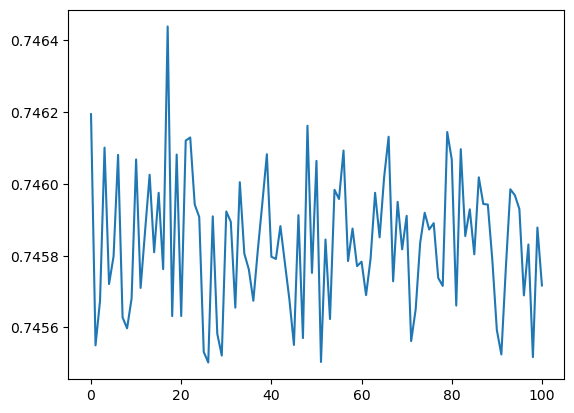

In [48]:
plt.plot(history.history["loss"])

In [ ]:
class StopOnAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc):
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy >= self.target_acc:
            print(f"\n\nReached accuracy {accuracy:.3%} — stopping!\n\n")
            self.model.stop_training = True

class SamplingLossEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"\n\nEpoch: {epoch} | Generated names:")
            for _ in range(7):
                name = get_sample_with_embedding(self.model)
                print(f"\t{name.title()}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-12)


X_padded = tf.keras.utils.pad_sequences(inputs[:], value=0, padding='post', dtype='int32')
Y_padded = tf.keras.utils.pad_sequences(outputs[:], value=0, padding='post', dtype='int32')

print(f"X_padded.shape = {X_padded.shape}")
print(f"Y_padded.shape = {Y_padded.shape}\n")

lstm_model = tf.keras.models.load_model("CONTINUE-dino_TOKENS_Embeddings_LSTM_Batch_Fit.keras")

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8, clipvalue=5.0)
lstm_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = lstm_model.fit(X_padded, Y_padded, batch_size=32, epochs=101, callbacks=[SamplingLossEpochCallback(), StopOnAccuracy(0.8), reduce_lr])
lstm_model.save("CONTINUE-dino_TOKENS_Embeddings_LSTM_Batch_Fit.keras")

plt.plot(history.history["loss"])

## Sampling with LSTM with Embedding loaded model

In [43]:
# emb_lstm = tf.keras.models.load_model("dino_TOKENS_Embeddings_LSTM_Batch_Fit.keras")
emb_lstm = tf.keras.models.load_model("CONTINUE-dino_TOKENS_Embeddings_LSTM_Batch_Fit.keras")

for _ in range(10):
    name = get_sample_with_embedding(emb_lstm)
    print(name.title())

Canyhedcanotan
Irgosaurus
Hoiszocoelus
Borealosaurus
Sphenospondylus
Lagerphodon
Nattosaurus
Zianospondylus
Leptospondylus
Winduhaetaktenatrix
